In [69]:
import os
from os.path import exists, join, dirname, basename
import sys
import glob 

import pandas as pd
import h5py
import numpy as np
import geopandas as gpd

import matplotlib.pyplot as plt

In [3]:
doc_dir = os.getcwd()
while basename(doc_dir) != 'Documents':
    doc_dir = dirname(doc_dir)
# dir of all gwfm data
gwfm_dir = dirname(doc_dir)+'/Box/research_cosumnes/GWFlowModel'
gwfm_dir

'C:\\Users\\andrewc/Box/research_cosumnes/GWFlowModel'

In [13]:
def add_path(fxn_dir):
    """ Insert fxn directory into first position on path so local functions supercede the global"""
    if fxn_dir not in sys.path:
        sys.path.insert(0, fxn_dir)
# flopy github path - edited
add_path(doc_dir+'/GitHub/flopy')
import flopy 

# other functions
py_dir = join(doc_dir,'GitHub/CosumnesRiverRecharge/python_utilities')
add_path(py_dir)

from mf_utility import get_layer_from_elev
from map_cln import gdf_bnds, plt_cln

In [4]:
end_date = pd.to_datetime('2020-09-30')
strt_date = pd.to_datetime('2001-10-01')

In [9]:
dem_data = np.loadtxt(gwfm_dir+'/DIS_data/dem_52_9_200m_mean.tsv')


In [26]:
# Load model grid as geopandas object
grid_p = gpd.read_file(gwfm_dir+'/DIS_data/grid/grid.shp')


In [19]:
uzf_dir = join(gwfm_dir, 'UZF_data')
nrow_p, ncol_p = 100,230
nrow, ncol = 100, 230

In [21]:
## Potential ETo spatial interpolation from CIMIS
fn = glob.glob(join(uzf_dir,'Cosumnes_dailyET_precip*.csv'))
daily_data = pd.DataFrame()
for file in fn:
    new_data = pd.read_csv(file, index_col = ['Date'], parse_dates = True)
    daily_data = pd.concat((daily_data, new_data))
# units of mm
data_in = daily_data[daily_data['Stn Name']=='Fair Oaks']
# clean up data so columns are by location, units of Precip are in mm
rain_in = data_in.pivot_table(index = 'Date', columns = 'Stn Name', values = 'Precip (mm)')
rain_m = rain_in/1000
# clean up data so columns are by location, units of Precip are in mm
ETo_in = data_in.pivot_table(index = 'Date', columns = 'Stn Name', values = 'ETo (mm)')
ETo_m = ETo_in/1000

# create array for every period of rainfall
rain_df = rain_m[strt_date:end_date].resample('D').interpolate('zero')['Fair Oaks']
rain_arr = np.repeat(np.repeat(np.reshape(rain_df.values, (rain_df.shape[0],1,1)), nrow, axis=1),ncol, axis=2)


In [13]:
def load_perc(strt_date, end_date):
    nper_tr = (end_date-strt_date).days+1
    # years and array index 
    years = pd.date_range(strt_date,end_date,freq='AS-Oct')
    yr_ind = (years-strt_date).days
    perc = np.zeros((nper_tr, nrow_p,ncol_p))
    # need separte hdf5 for each year because total is 300MB
    for n in np.arange(0,len(yr_ind)-1):
    #     arr = pc[yr_ind[n]:yr_ind[n+1]]
        fn = join(uzf_dir, 'basic_soil_budget',"percolation_WY"+str(years[n].year+1)+".hdf5")
        f = h5py.File(fn, "r")
        arr = f['array']['WY'][:]
        perc[yr_ind[n]:yr_ind[n+1]] = arr
    #     arr_to_h5(arr, fn)
        f.close()
    return(perc)

perc = load_perc(strt_date, end_date)
# percolation can't exceed vertical conductivity (secondary runoff)
# perc = np.where(perc >vka[0,:,:], vka[0,:,:], perc)

# ss_perc = load_perc(ss_strt, strt_date)
# # percolation can't exceed vertical conductivity (secondary runoff)
# ss_perc = np.where(ss_perc >vka[0,:,:], vka[0,:,:], ss_perc)

In [19]:
mean_perc = perc.mean(axis=0)

In [22]:
np.savetxt(join(gwfm_dir,'Cosumnes_RCH_pumping', 'regional_model_perc.txt'), mean_perc)

In [6]:
def dwr_etc(strt_date, end_date):
    nper_tr = (end_date-strt_date).days+1
    natETc = np.zeros((nper_tr,nrow_p,ncol_p))
    agETc = np.zeros((nper_tr,nrow_p,ncol_p))

    per_n = 0 
    for y in np.arange(strt_date.year, end_date.year+1):
        # set start and end date for range for the year to be iterated over
        yr_strt = pd.to_datetime(str(y)+'-01-01')
        yr_end = pd.to_datetime(str(y)+'-12-31')
        # get the length of the date range needed for that year
        yearlen = len(pd.date_range(yr_strt, yr_end))
        if yr_strt < strt_date:
            yr_strt = strt_date
        if yr_end > end_date:
            yr_end = end_date
        yr_len = len(pd.date_range(yr_strt, yr_end))
        # load hdf5 files
        f_irr = h5py.File(join(uzf_dir, "dwr_ETc/irrigated_"+str(y)+".hdf5"), "r")
        agETc[per_n:per_n+yr_len,:,:] = f_irr['array'][str(y)][:][yr_strt.dayofyear-1:yr_end.dayofyear,:,:]
        f_irr.close()
        f_nat = h5py.File(join(uzf_dir, "dwr_ETc/native_"+str(y)+".hdf5"), "r")
        natETc[per_n:per_n+yr_len,:,:] = f_nat['array'][str(y)][:][yr_strt.dayofyear-1:yr_end.dayofyear,:,:]
        f_nat.close()
        per_n += yr_len
    # make sure the return value is separate from the loop
    return(agETc, natETc)

In [36]:
agETc, natETc = dwr_etc(strt_date, end_date)
# net ETc should be ETc from ag and native plants joined
ETc = agETc + natETc

In [37]:
mean_agETc = agETc.mean(axis=0)


In [ ]:
np.savetxt(join(gwfm_dir,'Cosumnes_RCH_pumping', 'regional_model_agETc.txt'), mean_agETc)


In [7]:
wel_dir = join(gwfm_dir, 'WEL_data')

In [15]:
# load prepared daily domestic use data
dom_use = pd.read_csv(join(wel_dir, 'domestic_water_use.csv'), index_col=0, parse_dates=True)
dom_use = dom_use[strt_date:end_date]

# load data of locations of domestic wells
dom_loc = pd.read_csv(join(wel_dir, 'ag_res_parcel_domestic_wells.csv'), index_col=0)
# make row,column 0 based
dom_loc.row = (dom_loc.row-1).astype(int)
dom_loc.column = (dom_loc.column -1).astype(int)
# aggregate to the cell level, summing area will keep water usage scaling correct
dom_loc = dom_loc.groupby(['node','row','column', 'CITY']).sum(numeric_only=True).reset_index()
# get domestic well layers
# dom_wel_bot = (dem_data[dom_loc.row, dom_loc.column]- dom_loc.fill_depth_m).values
# dom_loc['layer'] = get_layer_from_elev(dom_wel_bot, botm[:,dom_loc.row, dom_loc.column], m.dis.nlay)

# use either the total area or expected fraction of irrigated area
# dom_loc['pump_scale'] = dom_loc.used_area_acres
dom_loc['pump_scale'] = dom_loc.area_acres
# since there appear to be higher pumping rates in wilton/sloughhouse based on observations
# i'm going to try different pumping scaling factors
# 2 times seemed like too much
# dom_loc.loc[dom_loc.CITY.isin(['WILTON']),'pump_scale'] *= 1.5 #'SLOUGHHOUSE'

In [33]:
# convert to arr to add to agEtc
dom_arr = np.zeros((nrow,ncol))
dom_arr[dom_loc.row, dom_loc.column] = dom_loc.pump_scale

In [22]:
# the coefficient for open water is 1.2 at all times
ET_water = ETo_m[strt_date:end_date]*1.2

In [48]:
water_surf = gpd.read_file(join(uzf_dir,'county_landuse','ag_lu_locally_defined.shp'))
water_surf = gpd.overlay(water_surf, grid_p)
water_surf['area_m2'] = water_surf.geometry.area
# make row,column 0 based
water_surf.row = (water_surf.row-1).astype(int)
water_surf.column = (water_surf.column -1).astype(int)
# determine layer
# water_surf['depth_m'] = ag_well_depth_arr[water_surf.row, water_surf.column]
# wel_bot_elev = dem_data[water_surf.row, water_surf.column] - water_surf.depth_m
# water_surf['layer'] = get_layer_from_elev(wel_bot_elev, botm[:,water_surf.row, water_surf.column], m.dis.nlay)

In [62]:
# for each stress period specify the flux of water surfaces 
water_surf['flux'] = ET_water.loc[strt_date:end_date,'Fair Oaks'].mean()*water_surf.area_m2
# wells_ws = water_surf[['layer','row','column','flux']].values
# spd_noag = np.vstack((wells_dom, wells_public, wells_ws))

In [63]:
# convert to arr to add to agEtc
water_arr = np.zeros((nrow,ncol))
water_arr[water_surf.row, water_surf.column] = water_surf.flux

In [57]:
# ET_water.mean().values[0]
# *water_surf.area_m2

0.004233096829971182

In [66]:
total_pump = mean_agETc*200*200+water_arr+dom_arr

In [71]:
np.savetxt(join(gwfm_dir,'Cosumnes_RCH_pumping', 'regional_model_pump_m3.txt'), total_pump)


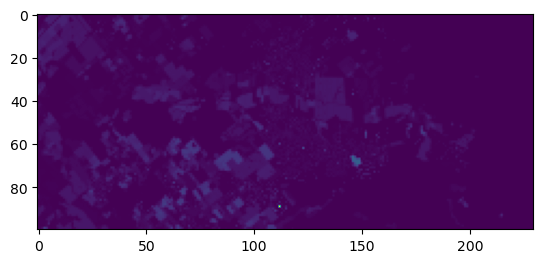

In [70]:
plt.imshow(total_pump)